In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [124]:
pizza_df = pd.read_excel('Pizza_Sale.xlsx', engine='openpyxl')
ingred_df = pd.read_excel('Pizza_ingredients.xlsx', engine='openpyxl')

In [126]:
pizza_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [128]:
pizza_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [130]:
pizza_df.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [132]:
pizza_df.dropna(inplace=True)

In [134]:
pizza_df.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [136]:
pizza_df.duplicated().sum()

0

In [138]:
pizza_df.shape

(48554, 12)

In [140]:
def parse_dates(date):
  for fmt in ('%d-%m-%Y', '%d/%m/%Y'):
    try:
      return pd.to_datetime(date, format=fmt)
    except ValueError:
      pass
  raise ValueError(f'no valid date format found for {date}')

In [142]:
pizza_df['order_date'] = pizza_df['order_date'].apply(parse_dates)

In [143]:
pizza_df['order_date'].head()

0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: order_date, dtype: datetime64[ns]

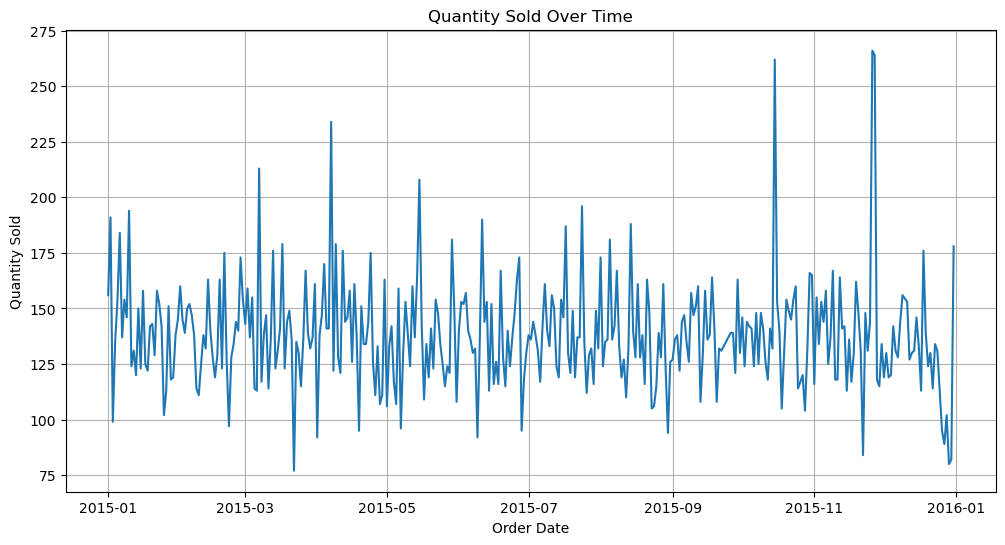

In [144]:

# Group by order date and sum the quantity
quantity_over_time = pizza_df.groupby('order_date')['quantity'].sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(quantity_over_time.index, quantity_over_time.values)
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold Over Time')
plt.grid(True)
plt.show()


## Autocorrelation and partial Autocorrelation

In [146]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

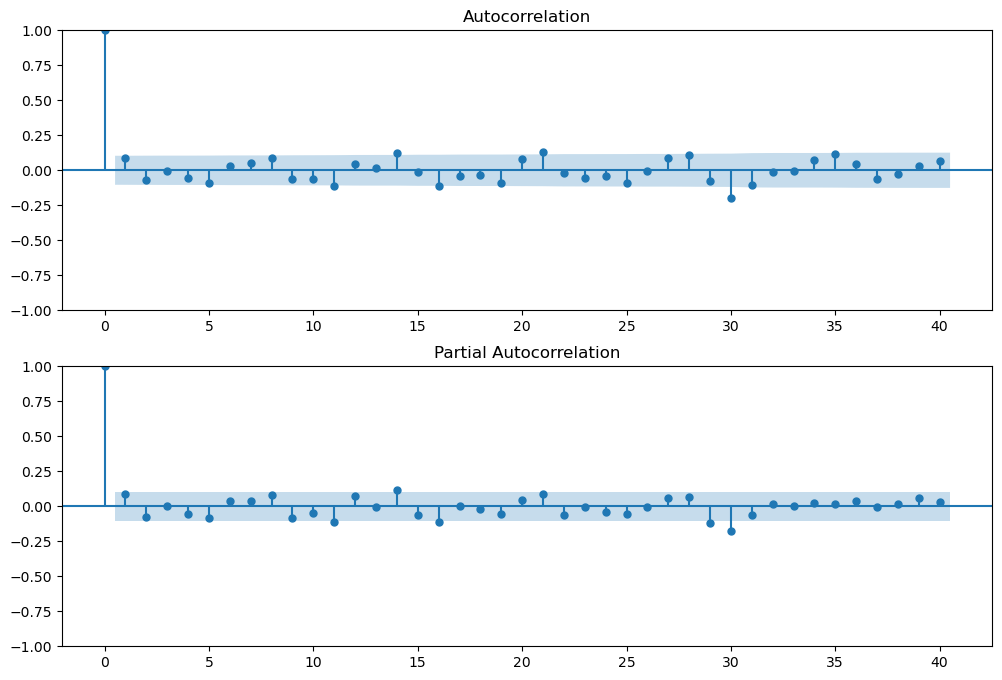

In [147]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(quantity_over_time, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(quantity_over_time, lags=40, ax=ax2)

P = 1

q = 1

d = 0

Testing for Stationary :

In [150]:
from statsmodels.tsa.stattools import adfuller

In [151]:
# H0: it is not stationary
# H1: it is stationary

def adf_test(sales):
  result = adfuller(sales)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print(f'# Lags used: {result[2]}')
  print(f'No of observations used: {result[3]}')
  if result[1] <= 0.05:
    print('we reject the null hypothesis, The series is stationary')
  else:
    print('Not enough statistical evidence to reject null hypothesis, The series is not stationary')

In [152]:
adf_test(quantity_over_time)

ADF Statistic: -4.919389
p-value: 0.000032
# Lags used: 15
No of observations used: 342
we reject the null hypothesis, The series is stationary


In [153]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [154]:
eval_data = pizza_df.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack().fillna(0)

In [157]:
eval_data.head()

pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,6.0,5.0,...,4.0,4.0,0.0,7.0,5.0,2.0,5.0,2.0,7.0,3.0
2015-01-02,12.0,9.0,3.0,7.0,15.0,3.0,2.0,13.0,5.0,6.0,...,6.0,5.0,3.0,9.0,9.0,5.0,3.0,4.0,8.0,1.0
2015-01-03,2.0,3.0,1.0,1.0,6.0,0.0,1.0,4.0,5.0,4.0,...,1.0,2.0,0.0,9.0,4.0,3.0,0.0,5.0,4.0,6.0
2015-01-04,2.0,3.0,0.0,2.0,3.0,3.0,2.0,8.0,7.0,6.0,...,4.0,8.0,6.0,10.0,4.0,4.0,6.0,1.0,3.0,5.0
2015-01-05,6.0,1.0,1.0,4.0,11.0,2.0,5.0,9.0,6.0,4.0,...,5.0,5.0,0.0,6.0,5.0,2.0,4.0,5.0,10.0,6.0


In [167]:
one_pizza = eval_data['The Barbecue Chicken Pizza']

In [169]:
# split train and test
train = one_pizza[:-7]
test = one_pizza[-7:]

In [171]:
# Fit Arima model
ari_model = ARIMA(train, order=(1, 1, 0))
ari_result = ari_model.fit()

In [173]:
# forecast
ari_forecast = ari_result.get_forecast(steps=len(test))
ari_fore_values = ari_forecast.predicted_mean

In [175]:
ari_predict = ari_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

In [177]:
ari_predict.index = test.index

In [179]:
# concat test and ari_predict without changing the index of test, test is a pandas series

concatenated_series = pd.concat([test, ari_predict], axis=1)
concatenated_series.columns = ['Actual', 'Predicted']
concatenated_series

,Actual,Predicted
order_date,,
2015-12-24,4.0,5.084266
2015-12-26,5.0,5.503550
2015-12-27,4.0,5.311574
2015-12-28,2.0,5.399474
2015-12-29,4.0,5.359227
2015-12-30,6.0,5.377655
2015-12-31,10.0,5.369217


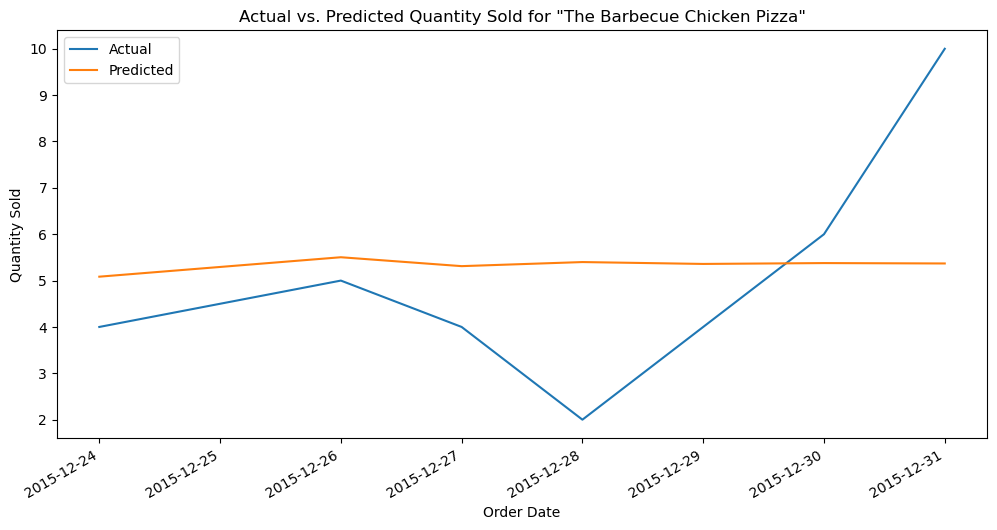

In [181]:
concatenated_series.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "The Barbecue Chicken Pizza"')
plt.show()

In [183]:
# Evaluate the model
mae = mean_absolute_error(test, ari_fore_values)
mse = mean_squared_error(test, ari_fore_values)
rmse = np.sqrt(mse)

print(f'ARIMA MAE: {mae}')
print(f'ARIMA MSE: {mse}')
print(f'ARIMA RMSE: {rmse}')

ARIMA MAE: 1.8444598200159243
ARIMA MSE: 5.483543168147393
ARIMA RMSE: 2.341696643066175


In [185]:
# fit SARIMA model
sari_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sari_result = sari_model.fit()

In [186]:
# sarima forecast
sari_forecast = sari_result.get_forecast(steps=len(test))
sari_fore_values = sari_forecast.predicted_mean

In [189]:
# Evaluate Sarima
mae = mean_absolute_error(test, sari_fore_values)
mse = mean_squared_error(test, sari_fore_values)
rmse = np.sqrt(mse)

print(f'SARIMAX MAE: {mae}')
print(f'SARIMAX MSE: {mse}')
print(f'SARIMAX RMSE: {rmse}')

SARIMAX MAE: 2.449548589903912
SARIMAX MSE: 7.643768556657406
SARIMAX RMSE: 2.764736616145814


In [191]:
sari_predict = sari_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

In [193]:
sari_predict.index = test.index

In [195]:
sari_predict

order_date
2015-12-24    7.519988
2015-12-26    6.311340
2015-12-27    5.876083
2015-12-28    6.496048
2015-12-29    6.131592
2015-12-30    6.517773
2015-12-31    6.705984
Name: predicted_mean, dtype: float64

In [197]:
concatenated_sarima = pd.concat([test, sari_predict] , axis=1)
concatenated_sarima.columns = ['Actual', 'Predicted']
concatenated_sarima

,Actual,Predicted
order_date,,
2015-12-24,4.0,7.519988
2015-12-26,5.0,6.311340
2015-12-27,4.0,5.876083
2015-12-28,2.0,6.496048
2015-12-29,4.0,6.131592
2015-12-30,6.0,6.517773
2015-12-31,10.0,6.705984


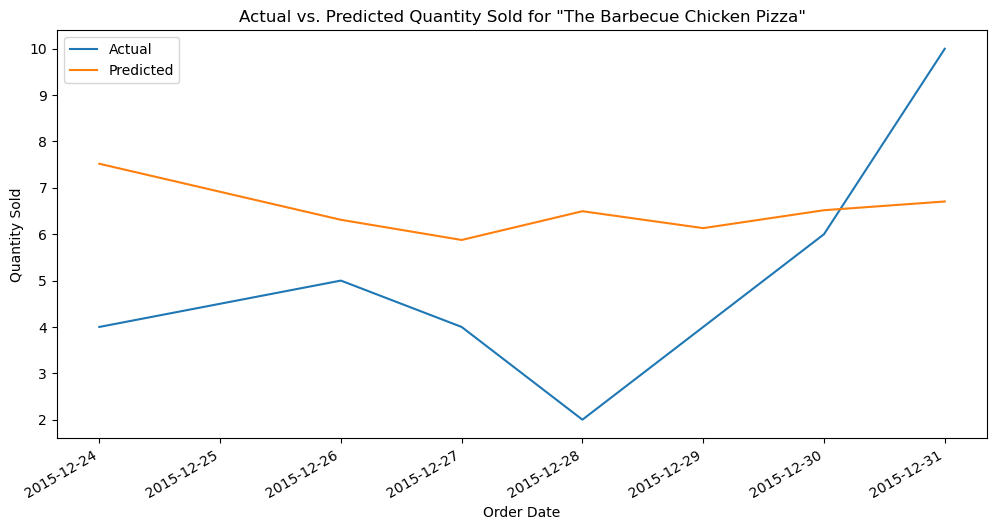

In [199]:
concatenated_sarima.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "The Barbecue Chicken Pizza"')
plt.show()

Prophet Evaluation

In [202]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [204]:
from prophet import Prophet

In [206]:
one_pizza_prophet = pd.DataFrame({'ds': one_pizza.index, 'y': one_pizza.values})

one_pizza_prophet.head()

,ds,y
0,2015-01-01,11.0
1,2015-01-02,12.0
2,2015-01-03,2.0
3,2015-01-04,2.0
4,2015-01-05,6.0


In [208]:
# one_pizza_prophet.set_index('ds', inplace=True)

# split train and test
pr_train = one_pizza_prophet[:-7]
pr_test = one_pizza_prophet[-7:]

In [210]:
# fit model prophet
pr_model = Prophet()
pr_model.fit(pr_train)

11:39:53 - cmdstanpy - INFO - Chain [1] start processing
11:39:53 - cmdstanpy - INFO - Chain [1] done processing


In [212]:
# forcast for one week
pr_future = pr_model.make_future_dataframe(periods=7, freq='D')
pr_forecast = pr_model.predict(pr_future)

In [214]:
# extract forecast values
pr_forecast_values = pr_forecast['yhat'][-len(pr_test):].values

In [216]:
# Evaluate the model
mae = mean_absolute_error(pr_test['y'], pr_forecast_values)
mse = mean_squared_error(pr_test['y'], pr_forecast_values)
rmse = np.sqrt(mse)

print(f'prophet MAE: {mae}')
print(f'prophet MSE: {mse}')
print(f'prophet RMSE: {rmse}')

prophet MAE: 2.648972543652011
prophet MSE: 8.227101395432305
prophet RMSE: 2.8682924180481155


In [218]:
concat_prophet = pd.concat([pr_test, pr_forecast[['yhat']].iloc[-len(pr_test):]], axis=1)
concat_prophet.columns = ['date','Actual', 'Predicted']
concat_prophet.set_index('date', inplace=True)
concat_prophet

,Actual,Predicted
date,,
2015-12-24,4.0,7.179194
2015-12-26,5.0,7.674544
2015-12-27,4.0,6.736572
2015-12-28,2.0,5.498497
2015-12-29,4.0,6.179417
2015-12-30,6.0,6.304937
2015-12-31,10.0,6.030353


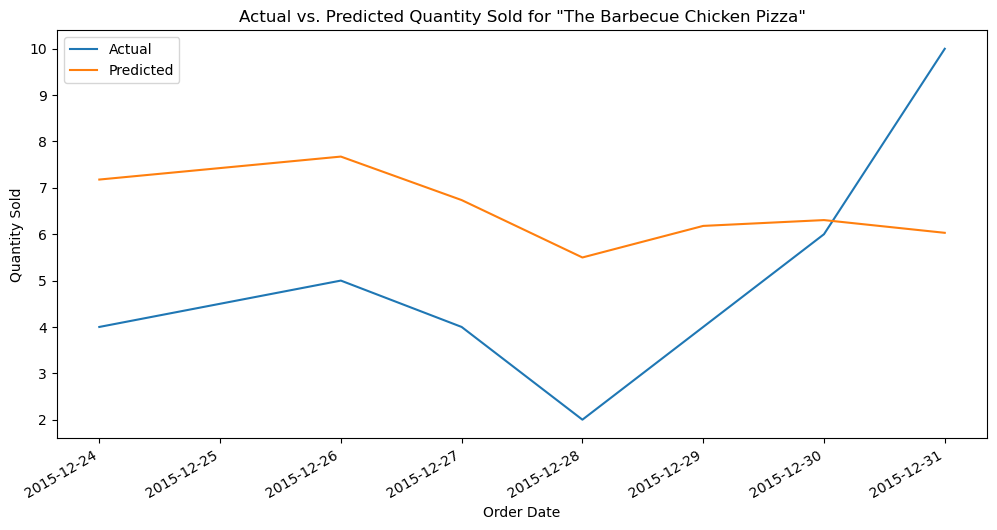

In [220]:
# visualize forecast
concat_prophet.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "The Barbecue Chicken Pizza"')
plt.show()